Load data, clean the data, combine separte data together, divide training data and test data.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#outdoor air temperature
oa = pd.read_csv("../data/oa_temp_utc_f.csv");
oa.columns = ['time', 'oa']
oa.set_index("time", drop = True, inplace = True);

oa.index = pd.to_datetime(oa.index)
oa = oa.replace('/', np.nan)
oa['oa'] = oa['oa'].astype(float)
oa = oa.interpolate(method = "time")

#relative humidity
rh = pd.read_csv("../data/rh_utc_perct.csv");
rh.columns = ['time', 'rh']
rh.set_index("time", drop = True, inplace = True);

rh.index = pd.to_datetime(rh.index)
rh = rh.replace('/', np.nan)
rh['rh'] = rh['rh'].astype(float)
rh = rh.interpolate(method = "time")

#solar radiation
sr = pd.read_csv("../data/total_solar_utc_btuh-ft2.csv");
sr.columns = ['time', 'sr'];
sr.set_index('time', drop = True, inplace = True);

sr.index = pd.to_datetime(sr.index)
sr = sr.replace('/', np.nan)
sr['sr'] = sr['sr'].astype(float)
sr = sr.interpolate(method = "time")
#wind speed
ws = pd.read_csv("../data/wind_speed_utc_mph.csv");
ws.columns = ['time', 'ws'];
ws.set_index('time', drop = True, inplace = True);

ws.index = pd.to_datetime(ws.index)
ws = ws.replace('/', np.nan)
ws['ws'] = ws['ws'].astype(float)
ws = ws.interpolate(method = "time")
#damper position of room 107n
dp = pd.read_csv("../data/107n_damper_utc_0to7or10.csv");
dp.columns = ['time', 'dp'];
dp.set_index('time', drop = True, inplace = True); 

dp.index = pd.to_datetime(dp.index)
dp = dp.replace('/', np.nan)
dp['dp'] = dp['dp'].astype(float)
dp = dp.interpolate(method = "time")
#some data has scale 0-10, some has scale 0-7, so transfer 0-7 to 0-10
dpUpper = dp.loc['2014-06-26 00:10:00':'2015-02-02 14:40:00',:];
dpLower = dp.loc['2015-02-02 14:50:00':,:]
dpLower = dpLower.multiply(10.0/7.0, axis='columns');

frames = [dpUpper, dpLower]
dp = pd.concat(frames)

#supply air temperature of room 107n
st = pd.read_csv("../data/107n_vavtemp_utc_f.csv");
st.columns = ['time', 'st'];
st.set_index('time', drop = True, inplace = True);

st.index = pd.to_datetime(st.index)
st = st.replace('/', np.nan)
st['st'] = st['st'].astype(float)
st = st.interpolate(method = "time");

#indoor air temperature of 107n
at = pd.read_csv("../data/107n_temp_utc_f.csv");
at.columns = ['time', 'at'];
at.set_index('time', drop = True, inplace = True);

at.index = pd.to_datetime(at.index)
at = at.replace('/', np.nan)
at['at'] = at['at'].astype(float)
at = at.interpolate(method = "time");

#merge together, change original utc time to local time
allDataRaw = (oa.merge(rh,how = 'inner',left_index = True, right_index = True)
              .merge(sr,how = 'inner',left_index = True, right_index = True)
              .merge(ws,how = 'inner',left_index = True, right_index = True)
              .merge(dp,how = 'inner',left_index = True, right_index = True)
              .merge(st,how = 'inner',left_index = True, right_index = True)
              .merge(at,how = 'inner',left_index = True, right_index = True));
import pytz
eastern = pytz.timezone('US/Eastern');
origIndex = allDataRaw.index;
newTimeIndex = origIndex.tz_localize(pytz.utc).tz_convert(eastern);
allDataRaw.index = newTimeIndex;

#add month, weekday, hour of day information
allDataRaw['month'] = allDataRaw.index;
allDataRaw['weekday'] = allDataRaw.index;
allDataRaw['hour'] = allDataRaw.index;
allDataRaw['month'] = (allDataRaw['month']
                             .apply(lambda x: x.month))
allDataRaw['weekday'] = (allDataRaw['weekday']
                             .apply(lambda x: x.weekday()))
allDataRaw['hour'] = (allDataRaw['hour']
                             .apply(lambda x: x.hour));

#seperate one year for train, one year for test
train = allDataRaw.loc['2014-11-01 00:00:00':'2015-11-01 00:00:00',:];
test = allDataRaw.loc['2015-11-01 00:10:00':'2016-11-01 00:10:00'];


In [16]:
from sklearn import tree
from sklearn import svm
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics

## Linear Regression

Train with the all year data using all input

In [17]:
# perform linear regresson using all data, all year round
X_train = train.ix[:,0:6].as_matrix()
X_test = test.ix[:,0:6].as_matrix()
y_train = train.ix[:,6].as_matrix()
y_test = test.ix[:,6].as_matrix()
coef = np.dot(np.linalg.pinv(X_train),y_train)
score = pd.DataFrame()
score_train = 1- np.sum((y_train - np.dot(X_train,coef))**2)/np.sum((y_train-y_train.mean())**2)
score_test = 1- np.sum((y_test - np.dot(X_test,coef))**2)/np.sum((y_test-y_test.mean())**2)
score = score.append(pd.Series([score_train,score_test]),ignore_index=True)
score.columns = ['Train', 'Test']
score

,Train,Test
0,-15.298957,-32.167091


Train with separate month using all input

In [18]:
# perform linear regression on all input, based on month
score = pd.DataFrame()
for i in range(1,13):
    X_train = train[train.index.month==i].ix[:,0:6].as_matrix()
    X_test = test[test.index.month==i].ix[:,0:6].as_matrix()
    y_train = train[train.index.month==i].ix[:,6].as_matrix()
    y_test = test[test.index.month==i].ix[:,6].as_matrix()
    coef = np.dot(np.linalg.pinv(X_train),y_train)
    score_train = 1- np.sum((y_train - np.dot(X_train,coef))**2)/np.sum((y_train-y_train.mean())**2)
    score_test = 1- np.sum((y_test - np.dot(X_test,coef))**2)/np.sum((y_test-y_test.mean())**2)
    score = score.append(pd.Series([score_train,score_test]),ignore_index=True)
score.columns = ['Train', 'Test']
score

,Train,Test
0,-11.988720,-30.525844
1,-10.868089,-26.167224
2,-24.475789,-14.728242
3,-11.878644,-13.027344
4,-9.843104,-13.282623
5,-16.808566,-15.962596
6,-2.841550,-13.368781
7,-1.351883,-33.274722
8,-6.654336,-8.900066
9,-7.477930,-8.457642


Train with separate month using outdoor temperature only

In [19]:
# using temperature only, based on month
score = pd.DataFrame()
for i in range(1,13):
    X_train = train[train.index.month==i].ix[:,0:1].as_matrix()
    X_test = test[test.index.month==i].ix[:,0:1].as_matrix()
    y_train = train[train.index.month==i].ix[:,1].as_matrix()
    y_test = test[test.index.month==i].ix[:,1].as_matrix()
    coef = np.dot(np.linalg.pinv(X_train),y_train)
    score_train = 1- np.sum((y_train - np.dot(X_train,coef))**2)/np.sum((y_train-y_train.mean())**2)
    score_test = 1- np.sum((y_test - np.dot(X_test,coef))**2)/np.sum((y_test-y_test.mean())**2)
    score = score.append(pd.Series([score_train,score_test]),ignore_index=True)
score.columns = ['Train', 'Test']
score

,Train,Test
0,-1.067981,-3.447268
1,-3.040050,-3.514593
2,-0.756276,-2.043472
3,-0.323740,-0.910045
4,-0.516582,-0.998874
5,-0.641723,-0.878842
6,-0.618210,-0.541280
7,-0.589922,-0.776048
8,-0.659337,-0.729487
9,-0.733638,-0.927275


Train with seasonal data using outdoor temperature only

In [20]:
# perform linear regression with temperature only, based on season (1-3, 4-6, 7-9, 10-12)
score = pd.DataFrame()
for i in range(4):
    X_train = train[np.logical_and(train.index.month>i*3, train.index.month<i*3+4)].ix[:,0:1].as_matrix()
    X_test = test[np.logical_and(test.index.month>i*3, test.index.month<i*3+4)].ix[:,0:1].as_matrix()
    y_train = train[np.logical_and(train.index.month>i*3, train.index.month<i*3+4)].ix[:,1].as_matrix()
    y_test = test[np.logical_and(test.index.month>i*3, test.index.month<i*3+4)].ix[:,1].as_matrix()
    coef = np.dot(np.linalg.pinv(X_train),y_train)
    score_train = 1- np.sum((y_train - np.dot(X_train,coef))**2)/np.sum((y_train-y_train.mean())**2)
    score_test = 1- np.sum((y_test - np.dot(X_test,coef))**2)/np.sum((y_test-y_test.mean())**2)
    score = score.append(pd.Series([score_train,score_test]),ignore_index=True)
score.columns = ['Train', 'Test']
score

,Train,Test
0,-1.541444,-3.193557
1,-0.311411,-0.615982
2,-0.621868,-0.636577
3,-1.073444,-0.763594


## Regression Tree

Train with all data using all input

In [21]:
# confiture features and output
X_train = train.ix[:,0:6].copy()
X_test = test.ix[:,0:6].copy()
y_train = train.ix[:,6].copy()
y_test = test.ix[:,6].copy()
# train the regression tree
reg_tree = tree.DecisionTreeRegressor()
reg_tree.fit(X_train,y_train)
result = reg_tree.feature_importances_
# test the regression tree with test data
print('The test score is '+ str(reg_tree.score(X_test,y_test)))
# present the feature importantce
feature_importance = pd.DataFrame()
feature_importance = feature_importance.append(pd.Series(result),ignore_index=True)
feature_importance.columns = ['oa', 'rh', 'sr', 'ws', 'dp', 'st']
feature_importance.index = ['feature importance']
feature_importance

The test score is 0.502956922991


,oa,rh,sr,ws,dp,st
feature importance,0.833288,0.042757,0.032674,0.00788,0.010299,0.073103


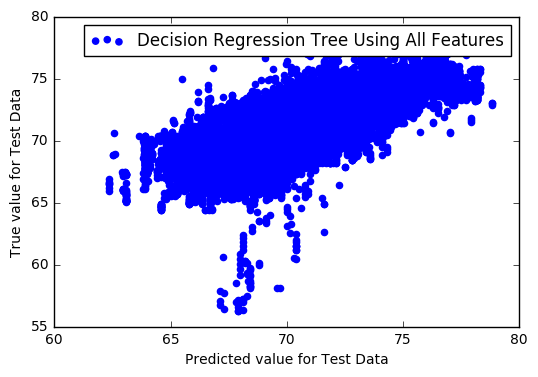

In [23]:
fig,ax = plt.subplots(facecolor='w')
ax.scatter(reg_tree.predict(X_test),y_test, color='b',label='Decision Regression Tree Using All Features')
ax.set_xlabel('Predicted value for Test Data')
ax.set_ylabel('True value for Test Data')
ax.legend()
plt.show()

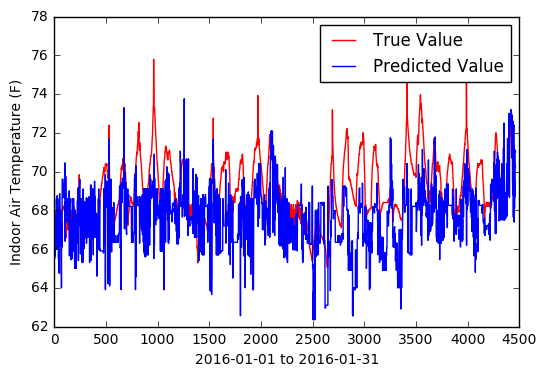

In [53]:
fig,ax = plt.subplots(facecolor='w')
num = len(test[test.index.month==1].index)
x = np.linspace(1,num,num)
ax.plot(x,test[test.index.month==1]['at'],color='r',label='True Value')
ax.plot(x,reg_tree.predict(X_test[X_test.index.month==1]),color='b',label='Predicted Value')
ax.legend()
ax.set_xlabel('2016-01-01 to 2016-01-31')
ax.set_ylabel('Indoor Air Temperature (F)')
plt.show()

Train with all data using outdoor temperature only

In [54]:
# use only temeprature to train 

# confiture features and output
X_train = train.ix[:,0:1].copy()
X_test = test.ix[:,0:1].copy()
y_train = train.ix[:,6].copy()
y_test = test.ix[:,6].copy()
# train the regression tree
reg_tree = tree.DecisionTreeRegressor()
reg_tree.fit(X_train,y_train)
result = reg_tree.feature_importances_
# test the regression tree with test data
print('The test score is '+ '%.4f'% reg_tree.score(X_test,y_test))

The test score is 0.4291


Train with separete month using all data

In [55]:
# use data from a particular month to train 
feature_importance = pd.DataFrame()

for i in range(1,13):
    # confiture features and output
    X_train = train[train.index.month==i].ix[:,0:6].copy()
    X_test = test[test.index.month==i].ix[:,0:6].copy()
    y_train = train[train.index.month==i].ix[:,6].copy()
    y_test = test[test.index.month==i].ix[:,6].copy()
    # train the regression tree
    reg_tree = tree.DecisionTreeRegressor()
    reg_tree.fit(X_train,y_train)
    result = reg_tree.feature_importances_
    # test the regression tree with test data
    print('The test score of month ' +str(i)+' is '+ '%.4f'% reg_tree.score(X_train,y_train)+' using training data, '+'%.4f'% reg_tree.score(X_test,y_test)+' using testing data.')
    # present the feature importantce
    feature_importance = feature_importance.append(pd.Series(result),ignore_index=True)

feature_importance.columns = ['oa', 'rh', 'sr', 'ws', 'dp', 'st']
#feature_importance

The test score of month 1 is 1.0000 using training data, -1.4847 using testing data.
The test score of month 2 is 1.0000 using training data, -1.0308 using testing data.
The test score of month 3 is 1.0000 using training data, -0.2435 using testing data.
The test score of month 4 is 1.0000 using training data, -0.0223 using testing data.
The test score of month 5 is 1.0000 using training data, 0.4227 using testing data.
The test score of month 6 is 1.0000 using training data, 0.4087 using testing data.
The test score of month 7 is 1.0000 using training data, -1.3116 using testing data.
The test score of month 8 is 1.0000 using training data, -0.6487 using testing data.
The test score of month 9 is 1.0000 using training data, -0.1311 using testing data.
The test score of month 10 is 1.0000 using training data, -0.0039 using testing data.
The test score of month 11 is 1.0000 using training data, 0.0366 using testing data.
The test score of month 12 is 1.0000 using training data, -0.1731 